# Project 2 - Sport Classification

### Maximilian Dermek, Marian Kurcina
<br>

## Table of Contents
- Data Analysis
- Data preprocessing and normalization
- Augmentations
- Data Split
- Code
- Configuration
- Experiment tracking
- Experiments
    - VGG style architecture
    - ResNet style architecture
        -  ResNet-34
        -  ResNet-18
        -  ResNet-34 with Dropout
        -  ResNet-18 with Dropout
- Conclusion

<br>

In [1]:
import kagglehub
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np

## Data Analysis

First we download the dateset from Kagglehub.

In [2]:
path = kagglehub.dataset_download("gpiosenka/sports-classification")
print(os.listdir(path))

100%|███████████████████████████████████████████████████████████████████████████████| 424M/424M [00:34<00:00, 12.7MB/s]

Extracting files...


['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'test', 'train', 'valid']


We can see dataset is split into three parts: train, validation and test. 

In [3]:
csv_path = os.path.join(path, "sports.csv")
df = pd.read_csv(csv_path)
print(df.head())
print(df.info())

   class id                 filepaths      labels data set
0         0  train/air hockey/001.jpg  air hockey    train
1         0  train/air hockey/002.jpg  air hockey    train
2         0  train/air hockey/003.jpg  air hockey    train
3         0  train/air hockey/004.jpg  air hockey    train
4         0  train/air hockey/005.jpg  air hockey    train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB
None


It also includes a CSV file containing the classes, file paths, labels of the images, and the dataset split they belong to.

In [4]:
print("Classes:", df['class id'].unique())
print("Number of classes:", df['class id'].nunique())

counts = df['class id'].value_counts()
print(counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Number of classes: 100
class id
31    201
32    200
58    199
7     184
41    182
     ... 
44    112
3     109
99    108
91    107
77     69
Name: count, Length: 100, dtype: int64


The dataset contains 100 classes, each with a different number of images.

In [5]:
train_count = df['filepaths'].str.startswith('train/').sum()
valid_count = df['filepaths'].str.startswith('valid/').sum()
test_count  = df['filepaths'].str.startswith('test/').sum()

print(f"Train images: {train_count}")
print(f"Valid images: {valid_count}")
print(f"Test images: {test_count}")

Train images: 13493
Valid images: 500
Test images: 500


Since the number of validation and test images is very small, we add additional samples from the training set.

In [6]:
import shutil

updated_rows = []

def move_files(rows, new_split):
        for _, row in rows.iterrows():
            old_path = row["filepaths"] 
            img_name = os.path.basename(old_path)
            img_name = f"{new_split}_{img_name}"
            new_path = os.path.join(new_split, row["labels"], img_name)

            old_abs = os.path.normpath(os.path.join(path, old_path))
            new_abs = os.path.normpath(os.path.join(path, new_path))

            os.makedirs(os.path.dirname(new_abs), exist_ok=True)
            shutil.move(old_abs, new_abs)

            new_row = row.copy()
            new_row["filepaths"] = new_path
            new_row["data set"] = new_split
            updated_rows.append(new_row)

for label in df["class id"].unique():
    class_rows = df[(df["class id"] == label) & (df["data set"] == "train")]
    
    test_samples = class_rows.sample(5)
    remaining = class_rows.drop(test_samples.index)
    val_samples = remaining.sample(5)
    remaining = class_rows.drop(val_samples.index)
    
    move_files(test_samples, "test")
    move_files(val_samples, "valid")

    remaining_train = df[(df["class id"] == label) & (df["data set"] == "train") \
                         & (~df.index.isin(test_samples.index)) \
                         & (~df.index.isin(val_samples.index))]

    for _, row in remaining_train.iterrows():
        updated_rows.append(row)


other_splits = df[df["data set"] != "train"]
updated_rows.extend([r for _, r in other_splits.iterrows()])
df = pd.DataFrame(updated_rows)
new_path = os.path.join(path, "new_sports.csv")
df.to_csv(new_path, index=False)

print(df.head())
print(df.info())

train_count = df['filepaths'].str.startswith('train').sum()
valid_count = df['filepaths'].str.startswith('valid').sum()
test_count  = df['filepaths'].str.startswith('test').sum()

print(f"Train images: {train_count}")
print(f"Valid images: {valid_count}")
print(f"Test images: {test_count}")

    class id                     filepaths      labels data set
53         0  test\air hockey\test_054.jpg  air hockey     test
93         0  test\air hockey\test_094.jpg  air hockey     test
2          0  test\air hockey\test_003.jpg  air hockey     test
47         0  test\air hockey\test_048.jpg  air hockey     test
91         0  test\air hockey\test_092.jpg  air hockey     test
<class 'pandas.core.frame.DataFrame'>
Index: 14493 entries, 53 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 566.1+ KB
None
Train images: 12493
Valid images: 1000
Test images: 1000


In [7]:
train_counts = df[df['filepaths'].str.startswith('train')]['class id'].value_counts()
print("Train counts per class:")
print(train_counts)

valid_counts = df[df['filepaths'].str.startswith('valid')]['class id'].value_counts()
print("\nValidation counts per class:")
print(valid_counts)

test_counts = df[df['filepaths'].str.startswith('test')]['class id'].value_counts()
print("\nTest counts per class:")
print(test_counts)

Train counts per class:
class id
31    181
32    180
58    179
7     164
41    162
     ... 
44     92
3      89
99     88
91     87
77     49
Name: count, Length: 100, dtype: int64

Validation counts per class:
class id
0     10
1     10
2     10
3     10
4     10
      ..
95    10
96    10
97    10
98    10
99    10
Name: count, Length: 100, dtype: int64

Test counts per class:
class id
0     10
1     10
2     10
3     10
4     10
      ..
95    10
96    10
97    10
98    10
99    10
Name: count, Length: 100, dtype: int64


([], [])

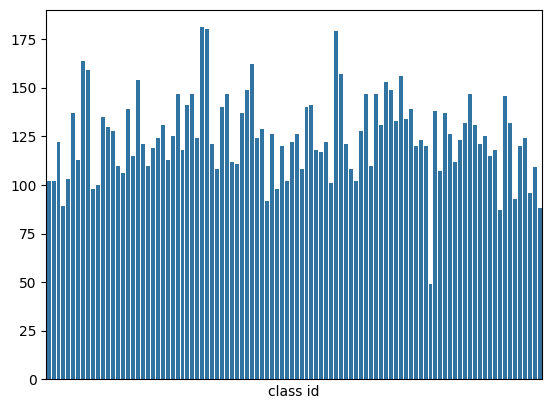

In [8]:
sns.barplot(x=train_counts.index, y=train_counts.values)
plt.xticks([])

([], [])

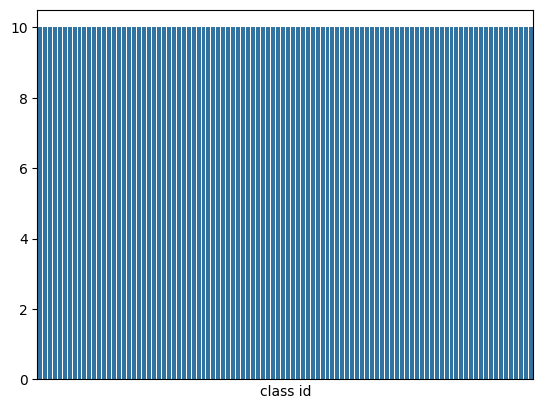

In [9]:
sns.barplot(x=valid_counts.index, y=valid_counts.values)
plt.xticks([])

([], [])

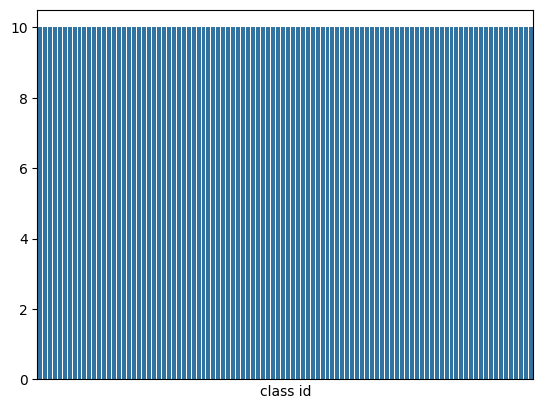

In [10]:
sns.barplot(x=test_counts.index, y=test_counts.values)
plt.xticks([])

After this adjustment, each class contains 10 images in both the validation and test sets.

Next, we verify that all images can be opened; any corrupted or unreadable images are removed. We also check whether all images have the same dimensions.

In [11]:
sizes = []
rows_to_drop = []


valid_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")

for idx,img_path in df['filepaths'].items():
    full_path = os.path.normpath(os.path.join(path, img_path))
    

    if not os.path.exists(full_path):
        rows_to_drop.append(idx)
        continue
    

    if not full_path.lower().endswith(valid_extensions):
        rows_to_drop.append(idx)
        continue

    img = Image.open(full_path)
    sizes.append(img.size)

if sizes:
    widths, heights = zip(*sizes)
    print("Width: min =", min(widths), "max =", max(widths))
    print("Height: min =", min(heights), "max =", max(heights))
else:
    print("No valid images found!")

df_clean = df.drop(index=rows_to_drop).reset_index(drop=True)

print(f"Dropped {len(rows_to_drop)} invalid images")
print(f"Remaining images: {len(df_clean)}")


Width: min = 224 max = 224
Height: min = 224 max = 224
Dropped 1 invalid images
Remaining images: 14492


## Data preprocessing and normalization

Since all images have identical sizes, preprocessing and normalization consist of encoding each pixel as a set of three numbers in the range 0–1, optionally applying augmentation.

In [12]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

NUM_CLASSES = df_clean['class id'].nunique()

In [13]:
def preprocess_image(img_path, label, augment=False):
    full_path = tf.strings.join([path, img_path], separator=os.sep)
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        pass
    
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

## Augmentations

For augmentation, we randomly flip images vertically and adjust brightness, contrast, saturation, and hue to introduce small variations. 

In [14]:
def preprocess_image(img_path, label, augment=False):
    full_path = tf.strings.join([path, img_path], separator=os.sep)
    img = tf.io.read_file(full_path)
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([224, 224, 3])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_saturation(img, 0.8, 1.2)
        img = tf.image.random_hue(img, 0.05)    
    
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

During training, we introduced additional augmentations:
- Random Rotation
- Random Affine
- Random Perspective

```
transforms.RandomRotation(20),
transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
```

## Data Split

Since the dataset already contains train, validation, and test splits, we only construct the corresponding PyTorch datasets. Augmentations are applied only to the training dataset.

In [15]:
def create_dataset(df_split, augment=False):
    paths = df_split['filepaths'].values
    labels = df_split['class id'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda x, y: preprocess_image(x, y, augment), 
                num_parallel_calls=tf.data.AUTOTUNE)
        
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_df = df_clean[df_clean['filepaths'].str.startswith('train')]
valid_df = df_clean[df_clean['filepaths'].str.startswith('valid')]
test_df  = df_clean[df_clean['filepaths'].str.startswith('test')]

train_ds_without_aug = create_dataset(train_df, augment=False)
train_ds = create_dataset(train_df, augment=True)
valid_ds = create_dataset(valid_df)
test_ds  = create_dataset(test_df)

## Final Data

Finally, we visualize the augmented samples and show how the images look after normalization when fed into the network.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.072254986..1.0300441].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10397208..1.0561786].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12445572..1.0195823].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05125746..1.023318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07588321..1.0373855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06593649..0.9286008].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0

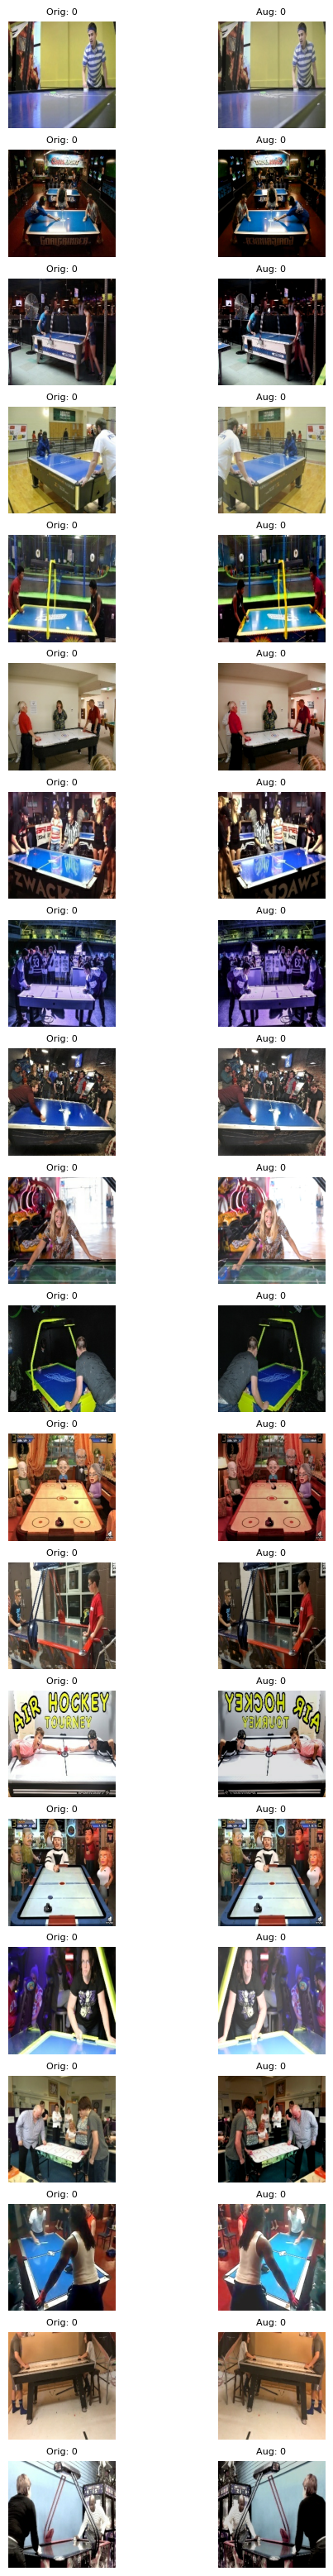

In [16]:
orig_batch = next(iter(train_ds_without_aug))
aug_batch  = next(iter(train_ds))

orig_images, orig_labels = orig_batch
aug_images, aug_labels   = aug_batch

plt.figure(figsize=(6, 40)) 
num_images = min(20, orig_images.shape[0]) 

for i in range(num_images):
    # Original
    ax = plt.subplot(20, 2, 2*i + 1)
    plt.imshow(orig_images[i].numpy())
    plt.axis("off")
    plt.title(f"Orig: {tf.argmax(orig_labels[i]).numpy()}", fontsize=8)

    # Augmented
    ax = plt.subplot(20, 2, 2*i + 2)
    plt.imshow(aug_images[i].numpy())
    plt.axis("off")
    plt.title(f"Aug: {tf.argmax(aug_labels[i]).numpy()}", fontsize=8)

plt.show()



We can see slightly different colours on images and we can see some images are fliped.

In [17]:
print("\n\n___IMAGE 0 (numeric values)___\n")
print(orig_images[0].numpy())



___IMAGE 0 (numeric values)___

[[[0.44313726 0.28627452 0.1882353 ]
  [0.21960784 0.07450981 0.        ]
  [0.1882353  0.0627451  0.01960784]
  ...
  [0.10196079 0.10980392 0.05490196]
  [0.08627451 0.09019608 0.06666667]
  [0.08627451 0.09411765 0.07450981]]

 [[0.48235294 0.31764707 0.21960784]
  [0.21960784 0.07058824 0.        ]
  [0.21176471 0.08627451 0.04313726]
  ...
  [0.10196079 0.10196079 0.05490196]
  [0.10196079 0.10588235 0.07450981]
  [0.08627451 0.09411765 0.07450981]]

 [[0.49803922 0.32156864 0.2       ]
  [0.3764706  0.21176471 0.11764706]
  [0.24313726 0.10196079 0.04705882]
  ...
  [0.10588235 0.10588235 0.05882353]
  [0.09803922 0.10196079 0.07058824]
  [0.08235294 0.09411765 0.06666667]]

 ...

 [[0.16470589 0.19215687 0.37254903]
  [0.16862746 0.19607843 0.36862746]
  [0.18039216 0.20784314 0.37254903]
  ...
  [0.2509804  0.27058825 0.15294118]
  [0.27058825 0.29411766 0.15294118]
  [0.2627451  0.28627452 0.13725491]]

 [[0.14901961 0.1764706  0.34901962]
  [

## Code 

The project contains four main files:
- config.py – Holds experiment parameters
- dataloader.py – Prepares training, validation, and test datasets
- model.py – Contains model classes
- trainer.py – Handles training, validation, testing, and Wandb logging

trainer.py is the main entry point for running experiments.

## Configuration

We introduced a configuration file (config.py) so users can easily adjust experiment parameters.
An example configuration:

```
from pathlib import Path
from model import CNN1, CNN1_2, CNN2

# Model
MODEL = CNN1()                  #CNN1(), CNN1_2(), CNN2()

# Training parameters
EPOCHS = 50
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 1e-4
LABEL_SMOOTHING = 0.1
NUM_WORKERS = 2
EARLY_STOP_PATIENCE = 10

# Output directory
OUT_DIR = Path("runs") / "sports_cnn_v1"

# Weights & Biases
USE_WANDB = True
WANDB_PROJECT = "zneus-project-2"
WANDB_ENTITY = "ZNEUS-Diabetes"
WANDB_RUN_NAME = "sports_cnn_model3_1"
WANDB_LOG_FREQUENCY = 500
```

The config contains configurations:
- MODEL - Name of the model architecture to use. The user defines model classes inside model.py, and this parameter selects which one to load for the experiment
- EPOCHS - Number of training epochs
- BATCH_SIZE - Number of samples per training batch
- LR (Learning Rate) - Step size used by the optimizer to update weights
- WEIGHT_DECAY - L2 regularization coefficient to reduce overfitting
- LABEL_SMOOTHING - Amount of label smoothing applied to the targets
- NUM_WORKERS - Number of CPU workers used by the DataLoader for parallel data loading
- EARLY_STOP_PATIENCE - Number of epochs to wait for improvement before early stopping is triggered
- OUT_DIR - Directory where logs, checkpoints, and results will be saved
- USE_WANDB - Flag to enable or disable Wandb experiment tracking
- WANDB_PROJECT - Name of the Wandb project where the run will be logged
- WANDB_ENTITY - Wandb entity (team or username) where the run will be stored
- WANDB_RUN_NAME - Custom name for the Wandb run
- WANDB_LOG_FREQUENCY - Frequency of the Wandb logging

## Experiment tracking

For experiment tracking we use Weights & Biases (Wandb).
Running the trainer initializes a new Wandb run, using metadata from the config file.

For each run we log the following metrics:

- f1_weighted,
- precision_weighted,
- recall_weighted,
- f1_macro,
- precision_macro,
- recall_macro,
- confusion_matrix,
- classification_report,
- specificity_per_class

During the run we track recall, precision, loss, f1 and accuracy for training, testing and validation.

![Wandb workspace](resources/IMG1.png)
![Statictics](resources/IMG2.png)
![Charts](resources/IMG3.png)

## Experiments

### VGG style architecture

First, we experimented with a VGG-16-style CNN consisting of five convolutional blocks, followed by global adaptive pooling and a fully connected classifier. 

The detailed architecture:

1.Block - Conv2D(3→32) → BN → ReLU → Conv2D(32→32) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.25)     
2.Block - Conv2D(32→64) → BN → ReLU → Conv2D(64→64) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)      
3.Block - Conv2D(64→128) → BN → ReLU → Conv2D(128→128) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)             
4.Block - Conv2D(128→256) → BN → ReLU → Conv2D(256→256) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.4)      
5.Block - Conv2D(256→512) → BN → ReLU → Conv2D(512→512) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.5)            
Global Adaptive Pooling       
Fully Connected Classifier - Flatten → Linear(512→512) → BN → ReLU → Dropout(0.5) → Linear(512→256) → BN → ReLU → Dropout(0.5) → Linear(256→100)

This model preformed relativelly great with no sign of overfitting. In the end the train accuracy was 0.837 which is similar to test and val accuracy

![Train Accuracy](resources/IMG4.png)
![Validation Accuracy](resources/IMG5.png)
![Class Accuracy](resources/IMG6.png)
![Confusion Matrix](resources/IMG7.png)

Test evaluation for the model:

accuracy -> 0.838     
f1       -> 0.843     
loss     -> 1.394     
precision -> 0.876    
recall   -> 0.838     



Validation evaluation for the model:

accuracy -> 0.836     
f1       -> 0.837     
loss     -> 1.450     
precision -> 0.863    
recall   -> 0.836     

We were advised to try a larger model, so next we tested a version with wider convolutional blocks:

1.Block - Conv2D(3→64) → BN → ReLU → Conv2D(64→64) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.25)                   
2.Block - Conv2D(64→128) → BN → ReLU → Conv2D(128→128) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)                  
3.Block - Conv2D(128→256) → BN → ReLU → Conv2D(256→256) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)                 
4.Block - Conv2D(256→512) → BN → ReLU → Conv2D(512→512) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.4)                  
5.Block - Conv2D(512→512) → BN → ReLU → Conv2D(512→512) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.5)                       
Global Adaptive Pooling                                  
Fully Connected Classifier - Flatten → Linear(512→512) → BN → ReLU → Dropout(0.5) → Linear(512→256) → BN → ReLU → Dropout(0.5) → Linear(256→100)

The improvement was not significant (it was actually worse), so we moved on to ResNet-style architectures. 

![Train Accuracy](resources/IMG8.png)
![Validation Accuracy](resources/IMG9.png)


Test evaluation for the model:

accuracy -> 0.816     
f1       -> 0.823     
loss     -> 1.428     
precision -> 0.860    
recall   -> 0.816     



Validation evaluation for the model:

accuracy -> 0.816    
f1       -> 0.827     
loss     -> 1.458     
precision -> 0.870    
recall   -> 0.816     

### ResNet style architecture

#### ResNet-34

We first tried a ResNet-34-like model without dropout.
Furthermore we use Kaiming Initialization for the weights -> https://www.geeksforgeeks.org/deep-learning/kaiming-initialization-in-deep-learning/

Stem: Conv2D(3→64, 7×7, stride=2, padding=3) → BN → ReLU → MaxPool2D(3×3, stride=2, padding=1)                   
Layer 1: 3 residual blocks, each: Conv3×3(64→64) → BN → ReLU → Conv3×3(64→64) → BN                          
Layer 2 : 4 residual blocks, each: Conv3×3(64→128) → BN → ReLU → Conv3×3(128→128) → BN, with stride=2             
Layer 3: 6 residual blocks, each: Conv3×3(128→256) → BN → ReLU → Conv3×3(256→256) → BN, with stride=2                
Layer 4: 3 residual blocks, each: Conv3×3(256→512) → BN → ReLU → Conv3×3(512→512) → BN, with stride=2             
Global Adaptive Pooling                   
Classifier: Flatten → Linear(512→100)              

Inspiration: https://www.geeksforgeeks.org/deep-learning/residual-networks-resnet-deep-learning/, 

This architecture overfitted quickly, reaching near-100% training accuracy early. Therefore we decided to try smaller model - ResNet-18.

![Train Accuracy](resources/IMG12.png)
![Validation Accuracy](resources/IMG13.png)
![Class Accuracy](resources/IMG14.png)
![Confusion Matrix](resources/IMG15.png)

Test evaluation for the model:

accuracy -> 0.84      
f1       -> 0.843     
loss     -> 1.412     
precision -> 0.871    
recall   -> 0.84      



Validation evaluation for the model:


accuracy -> 0.832     
f1       -> 0.832     
loss     -> 1.468     
precision -> 0.858    
recall   -> 0.83      

#### ResNet-18

Since ResNet-34 was too large, we also tried out ResNet-18.
It follows the same structure with fewer residual blocks:
- 2, 2, 2, 2 blocks across the four layers

Stem: Conv2D(3→64, 7×7, stride=2, padding=3) → BN → ReLU → MaxPool2D(3×3, stride=2, padding=1)                   
Layer 1: 2 residual blocks, each: Conv3×3(64→64) → BN → ReLU → Conv3×3(64→64) → BN                          
Layer 2 : 2 residual blocks, each: Conv3×3(64→128) → BN → ReLU → Conv3×3(128→128) → BN, with stride=2             
Layer 3: 2 residual blocks, each: Conv3×3(128→256) → BN → ReLU → Conv3×3(256→256) → BN, with stride=2                
Layer 4: 2 residual blocks, each: Conv3×3(256→512) → BN → ReLU → Conv3×3(512→512) → BN, with stride=2             
Global Adaptive Pooling                   
Classifier: Flatten → Linear(512→100)   

Inspiration: https://www.geeksforgeeks.org/deep-learning/resnet18-from-scratch-using-pytorch/

This model also overfitted. Therefore we have decided to introduce dropout into our network.

![Train Accuracy](resources/IMG16.png)
![Validation Accuracy](resources/IMG17.png)
![Class Accuracy](resources/IMG18.png)
![Confusion Matrix](resources/IMG19.png)

Test evaluation for the model:

accuracy -> 0.852     
f1       -> 0.859     
loss     -> 1.331     
precision -> 0.890   
recall   -> 0.852     



Validation evaluation for the model:

accuracy -> 0.844     
f1       -> 0.847     
loss     -> 1.363     
precision -> 0.873    
recall   -> 0.844   

#### ResNet-34 with dropout

To address overfitting, we introduced dropout inside each residual block. The architecture is identical to ResNet-34, with the addition of dropout after the ReLU in each block.
We tested dropout values of 0.05, 0.1, 0.2, and 0.25.

Stem: Conv2D(3→64, 7×7, stride=2, padding=3) → BN → ReLU → MaxPool2D(3×3, stride=2, padding=1)                   
Layer 1: 3 residual blocks, each: Conv3×3(64→64) → BN → ReLU → Dropout → Conv3×3(64→64) → BN                          
Layer 2 : 4 residual blocks, each: Conv3×3(64→128) → BN → ReLU → Dropout → Conv3×3(128→128) → BN, with stride=2             
Layer 3: 6 residual blocks, each: Conv3×3(128→256) → BN → ReLU → Dropout → Conv3×3(256→256) → BN, with stride=2                
Layer 4: 3 residual blocks, each: Conv3×3(256→512) → BN → ReLU → Dropout → Conv3×3(512→512) → BN, with stride=2             
Global Adaptive Pooling                   
Classifier: Flatten → Linear(512→100)   

This significantly reduced overfitting.

![Train Accuracy](resources/IMG20.png)
![Validation Accuracy](resources/IMG21.png)
![Class Accuracy](resources/IMG22.png)
![Confusion Matrix](resources/IMG23.png)

Test evaluation for the model:

 accuracy  -> 0.793     
 f1        -> 0.797     
 loss      -> 1.537     
 precision -> 0.824   
 recall    -> 0.793     


Validation evaluation for the model:

accuracy -> 0.796     
f1       -> 0.795     
loss     -> 1.532     
precision -> 0.814    
recall   -> 0.796     

#### ResNet-18 with dropout

We have tried the same strategy with dropout with ResNet-18. The architecture of model:

Stem: Conv2D(3→64, 7×7, stride=2, padding=3) → BN → ReLU → Dropout → MaxPool2D(3×3, stride=2, padding=1)                   
Layer 1: 2 residual blocks, each: Conv3×3(64→64) → BN → ReLU → Dropout → Conv3×3(64→64) → BN                          
Layer 2 : 2 residual blocks, each: Conv3×3(64→128) → BN → ReLU → Dropout → Conv3×3(128→128) → BN, with stride=2             
Layer 3: 2 residual blocks, each: Conv3×3(128→256) → BN → ReLU → Dropout → Conv3×3(256→256) → BN, with stride=2                
Layer 4: 2 residual blocks, each: Conv3×3(256→512) → BN → ReLU → Dropout → Conv3×3(512→512) → BN, with stride=2             
Global Adaptive Pooling                   
Classifier: Flatten → Linear(512→100)   

This has significantly reduced the overfitting too.

![Train Accuracy](resources/IMG24.png)
![Validation Accuracy](resources/IMG25.png)
![Class Accuracy](resources/IMG26.png)
![Confusion Matrix](resources/IMG27.png)

Test evaluation for the model:

 accuracy  -> 0.793     
 f1        -> 0.797     
 loss      -> 1.537     
 precision -> 0.824   
 recall    -> 0.793     


Validation evaluation for the model:

accuracy -> 0.796     
f1       -> 0.795     
loss     -> 1.532     
precision -> 0.814    
recall   -> 0.796    

## Conclusion

We have tested different model architectures, tested with parameters and found the model with 83.8% accuracy. This model is VGG based. We have tried to find better model by increasing the model size, but this was not effective. We hav experimented with different model architecture but this didnt improve our performance.
The best model we have found:

1.Block - Conv2D(3→32) → BN → ReLU → Conv2D(32→32) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.25)     
2.Block - Conv2D(32→64) → BN → ReLU → Conv2D(64→64) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)      
3.Block - Conv2D(64→128) → BN → ReLU → Conv2D(128→128) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.3)             
4.Block - Conv2D(128→256) → BN → ReLU → Conv2D(256→256) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.4)      
5.Block - Conv2D(256→512) → BN → ReLU → Conv2D(512→512) → BN → ReLU → MaxPool2D(2×2) → Dropout(0.5)            
Global Adaptive Pooling       
Fully Connected Classifier - Flatten → Linear(512→512) → BN → ReLU → Dropout(0.5) → Linear(512→256) → BN → ReLU → Dropout(0.5) → Linear(256→100)

Metrics:

accuracy -> 0.838     
f1       -> 0.843     
loss     -> 1.394     
precision -> 0.876    
recall   -> 0.838     


Validation evaluation for the model:

accuracy -> 0.836     
f1       -> 0.837     
loss     -> 1.450     
precision -> 0.863    
recall   -> 0.836  

This model is not overfit since it performs comparably on both training dataset and validation/test datasets. 